In [1]:
# Setup the library
import pyrogue as pr
import os
top_level=f'{os.getcwd()}/..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import rfsoc_4x2_photon_detector_dev
import numpy as np
import matplotlib.pyplot as plt
import time

# Create and start the root class
root = rfsoc_4x2_photon_detector_dev.Root(
    ip          = '10.0.0.10', # RFSoC's IP address
    defaultFile = 'config/defaults.yml',
    top_level   = top_level,
)

# Start the root device
root.start()

# Display 1Hz auto-triggering
root.RFSoC.Application.EnableSoftTrig.set(False)

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Hardware.SpiBridge.Regs.ResetHw()
Loading path=/afs/slac.stanford.edu/u/re/ruckman/projects/rfsoc-4x2-photon-detector-dev/software/notebooks/../config/defaults.yml Default Configuration File...


In [2]:
# Create useful pointers
AxiVersion = root.RFSoC.AxiSocCore.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = Root.RFSoC.AxiSocCore.AxiVersion
FwVersion    = 0x1000000
UpTime       = 2:50:22
GitHash      = dirty (uncommitted code)
XilinxDnaId  = 0x400200000150792825906285
FwTarget     = Rfsoc4x2PhotonDetectorDev
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv403 (Ubuntu 22.04.2 LTS)
BuildDate    = Mon Apr 24 07:19:25 PM PDT 2023
Builder      = ruckman
###################################################


In [3]:
# Create a function to trigger the waveform ring buffers
def TrigRingBuffer():
    # Trigger a ADC/DAC ring buffer update
    root.PvAdc[0].Updated.set(False)
    root.RFSoC.Application.StartDacFlag.set(1)
    root.RFSoC.Application.StartDacFlag.set(0)

    # Wait for Waveform
    while(root.PvAdc[0].Updated.get() != True):
        time.sleep(0.01)
        
# Create function to plot the ADC/DAC waveforms
def PlotWavform():
    fig, axs = plt.subplots(2)
    axs[0].plot(root.PvAdc[0].Time.value(),root.PvAdc[0].WaveformData.value())
    axs[1].plot(root.PvDac[0].Time.value(),root.PvDac[0].WaveformData.value())
    axs[0].grid()
    axs[1].grid()
    axs[0].set_xlabel("Time (ns)")  
    axs[1].set_xlabel("Time (ns)")  
    axs[0].set_ylabel("ADC Counts") 
    axs[1].set_ylabel("DAC Counts") 
    
# Create function to trigger then plot waveforms
def TriggerThenPlotWavform():  
    TrigRingBuffer()
    PlotWavform()

![title](img/SiPMSignal.png)

In [4]:
# Print the current default values for indent time, amplitude, decay and rise
print( f'Amplitude={root.RFSoC.Application.SigGenLoader.Amplitude.value()}')
print( f'Decay={root.RFSoC.Application.SigGenLoader.Decay.value()}')
print( f'Rise={root.RFSoC.Application.SigGenLoader.Rise.value()}')
print( f'IncidentTime={root.RFSoC.Application.SigGenLoader.IncidentTime.value()}')

Amplitude=[25000     0     0     0]
Decay=[1.e-07 1.e-07 1.e-07 1.e-07]
Rise=[1.e-08 1.e-08 1.e-08 1.e-08]
IncidentTime=[4.00e-06 4.25e-06 6.00e-06 7.00e-06]


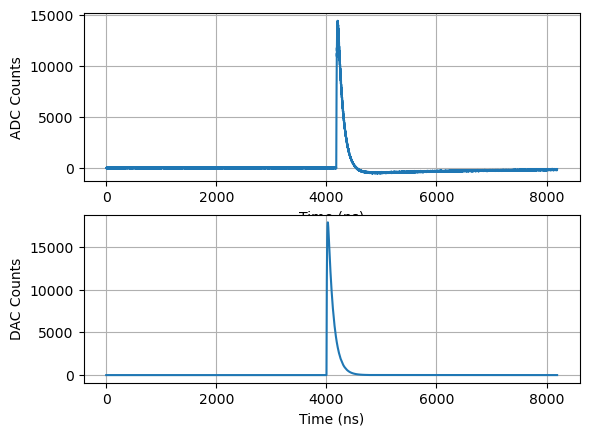

In [5]:
# Diplay the default values loaded into SiPM signal generator
TriggerThenPlotWavform()

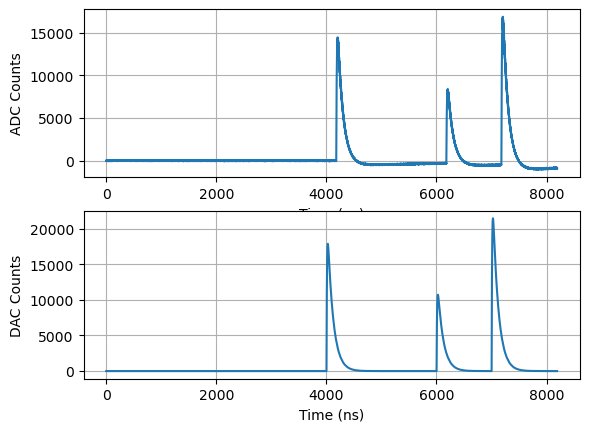

In [6]:
# Enable the 3rd and 4th SiPM pulse that don't overlap with the 1st
root.RFSoC.Application.SigGenLoader.Amplitude.set([25000, 0, 15000, 30000])
root.RFSoC.Application.SigGenLoader.LoadWaveform()

# Trigger and display new data
TriggerThenPlotWavform()

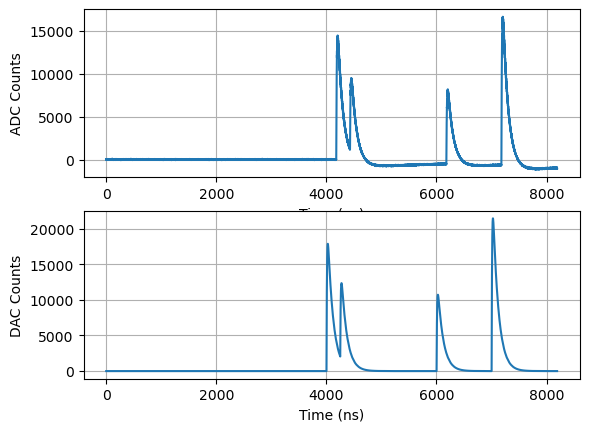

In [7]:
# Enable the 2nd pulse, which is superposited on the 1st pulse
root.RFSoC.Application.SigGenLoader.Amplitude.set([25000, 15000, 15000, 30000])
root.RFSoC.Application.SigGenLoader.LoadWaveform()

# Trigger and display new data
TriggerThenPlotWavform()

In [8]:
# Stop the root device
root.stop()